In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import spacy
from nltk.corpus import stopwords
# nltk.download('stopwords')
from collections import Counter
from sklearn import model_selection, feature_extraction, metrics
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier


Import data set:


In [2]:
pd.options.mode.chained_assignment = None

col_list = ['text', 'class']
df_full = pd.read_csv('data/data_set_updated.csv', usecols=col_list)
df = df_full[['text']]

df["text"] = df["text"].astype(str)
df_full.head()
df.head()


,text
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ..."
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ..."
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π..."
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα..."
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι..."


# Text preprocessing:


## lower casing:


In [3]:

df["text_lower"] = df["text"].str.lower()
df.head()
# drop the new column created in last cell
# df.drop(["text_lower"], axis=1, inplace=True)


,text,text_lower
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...","""ξεκίνησε το πρωί ενώπιον των δικαστών του μικ..."
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...","""στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ..."
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...","""δεν λέει κουβέντα ο γερμανός καταδικασμένος π..."
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...","""2,5 χρόνια μετά από τον θάνατο της ειρήνης λα..."
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...","""μία εβδομάδα μετά την αρχική του εκτίμηση ότι..."


## remove punctuation


In [4]:
punctuation = '«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»●·’“”'
PUNCT_TO_REMOVE = punctuation


def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


df["text_wo_punct"] = df["text_lower"].apply(
    lambda text: remove_punctuation(text))
df.head()


,text,text_lower,text_wo_punct
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...","""ξεκίνησε το πρωί ενώπιον των δικαστών του μικ...",ξεκίνησε το πρωί ενώπιον των δικαστών του μικτ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...","""στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσε...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...","""δεν λέει κουβέντα ο γερμανός καταδικασμένος π...",δεν λέει κουβέντα ο γερμανός καταδικασμένος πα...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...","""2,5 χρόνια μετά από τον θάνατο της ειρήνης λα...",25 χρόνια μετά από τον θάνατο της ειρήνης λαγο...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...","""μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",μία εβδομάδα μετά την αρχική του εκτίμηση ότι ...


## remove stopwords:


In [5]:
STOPWORDS_GREEK = set(stopwords.words('greek'))


def import_additional_greek_stopwords(STOPWORDS_GREEK):
    STOPWORDS_GREEK.add('της')
    STOPWORDS_GREEK.add('από')
    STOPWORDS_GREEK.add('είναι')
    STOPWORDS_GREEK.add('έχει')
    STOPWORDS_GREEK.add('σας')
    STOPWORDS_GREEK.add('τους')
    STOPWORDS_GREEK.add('τη')
    STOPWORDS_GREEK.add('μας')
    STOPWORDS_GREEK.add('στα')
    STOPWORDS_GREEK.add('στις')
    STOPWORDS_GREEK.add('στους')
    STOPWORDS_GREEK.add('μου')
    STOPWORDS_GREEK.add('σου')
    return STOPWORDS_GREEK


STOPWORDS_GREEK = import_additional_greek_stopwords(STOPWORDS_GREEK)


def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS_GREEK])


df["text_wo_stop"] = df["text_wo_punct"].apply(
    lambda text: remove_stopwords(text))
df.head()


,text,text_lower,text_wo_punct,text_wo_stop
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...","""ξεκίνησε το πρωί ενώπιον των δικαστών του μικ...",ξεκίνησε το πρωί ενώπιον των δικαστών του μικτ...,ξεκίνησε πρωί ενώπιον δικαστών μικτού ορκωτού ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...","""στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσε...,άλλο άκρο έχουν περάσει πλέον διαδηλώσεις ηπα ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...","""δεν λέει κουβέντα ο γερμανός καταδικασμένος π...",δεν λέει κουβέντα ο γερμανός καταδικασμένος πα...,λέει κουβέντα γερμανός καταδικασμένος παιδόφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...","""2,5 χρόνια μετά από τον θάνατο της ειρήνης λα...",25 χρόνια μετά από τον θάνατο της ειρήνης λαγο...,25 χρόνια θάνατο ειρήνης λαγούδη μητέρας τριών...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...","""μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",μία εβδομάδα μετά την αρχική του εκτίμηση ότι ...,μία εβδομάδα αρχική εκτίμηση ότι μαντλίν μακκα...


## remove intonation:


In [6]:
def remove_intonation(text):

    rep = {"ά": "α", "έ": "ε", "ή": "η", "ί": "ι", "ό": "ο", "ύ": "υ", "ώ": "ω", "ϊ": "ι",
           "ἀ": "α", "ἐ": "ε", "ἤ": "η", "ἰ": "ι", "ἄ": "α", "ὐ": "υ", "ὡ": "ω", "ὦ": "ω",
           'ὖ': 'υ', 'ὅ': 'ο', 'ῆ': 'η', 'ῇ': 'η', 'ῦ': 'υ', 'ὁ': 'ο', 'ὑ': 'υ', 'ὲ': 'ε',
           'ὺ': 'υ', 'ἂ': 'α', 'ἵ': 'ι', 'ὴ': 'η', 'ὰ': 'α', 'ἅ': 'α', 'ὶ': 'ι', 'ἴ': 'ι',
           'ὸ': 'ο', 'ἥ': 'η', 'ἡ': 'η', 'ὕ': 'υ', 'ἔ': 'ε', 'ἳ': 'ι', 'ὗ': 'υ', 'ἃ': 'α',
           'ὃ': 'ο', 'ὥ': 'ω', 'ὔ': 'υ', 'ῖ': 'ι', 'ἣ': 'η', 'ἷ': 'ι', 'ἑ': 'ε', 'ᾧ': 'ω',
           'ἢ': 'η', 'ΐ': 'ι', }

    rep = dict((nltk.re.escape(k), v) for k, v in rep.items())
    pattern = nltk.re.compile("|".join(rep.keys()))
    text = pattern.sub(lambda m: rep[nltk.re.escape(m.group(0))], text)

    return text


df["text_wo_intonation"] = df["text_wo_stop"].apply(
    lambda text: remove_intonation(text))
df.head()


,text,text_lower,text_wo_punct,text_wo_stop,text_wo_intonation
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...","""ξεκίνησε το πρωί ενώπιον των δικαστών του μικ...",ξεκίνησε το πρωί ενώπιον των δικαστών του μικτ...,ξεκίνησε πρωί ενώπιον δικαστών μικτού ορκωτού ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...","""στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσε...,άλλο άκρο έχουν περάσει πλέον διαδηλώσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...","""δεν λέει κουβέντα ο γερμανός καταδικασμένος π...",δεν λέει κουβέντα ο γερμανός καταδικασμένος πα...,λέει κουβέντα γερμανός καταδικασμένος παιδόφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...","""2,5 χρόνια μετά από τον θάνατο της ειρήνης λα...",25 χρόνια μετά από τον θάνατο της ειρήνης λαγο...,25 χρόνια θάνατο ειρήνης λαγούδη μητέρας τριών...,25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...","""μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",μία εβδομάδα μετά την αρχική του εκτίμηση ότι ...,μία εβδομάδα αρχική εκτίμηση ότι μαντλίν μακκα...,μια εβδομαδα αρχικη εκτιμηση οτι μαντλιν μακκα...


## remove frequent words:


### get most frequent words:


In [7]:
cnt = Counter()
for text in df["text_wo_intonation"].values:
    for word in text.split():
        cnt[word] += 1

# show ten more frequent elements:
cnt.most_common(10)


[('οτι', 1574),
 ('ειχε', 912),
 ('ηταν', 726),
 ('μια', 705),
 ('συμφωνα', 552),
 ('δυο', 544),
 ('οπως', 526),
 ('ενω', 515),
 ('ενα', 497),
 ('αλλα', 496)]

### remove most frequent words:


In [8]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])


def remove_freqwords(text):
    """custom function to remove frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])


df["text_wo_freq"] = df["text_wo_intonation"].apply(
    lambda text: remove_freqwords(text))
df.head()


,text,text_lower,text_wo_punct,text_wo_stop,text_wo_intonation,text_wo_freq
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...","""ξεκίνησε το πρωί ενώπιον των δικαστών του μικ...",ξεκίνησε το πρωί ενώπιον των δικαστών του μικτ...,ξεκίνησε πρωί ενώπιον δικαστών μικτού ορκωτού ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...","""στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσε...,άλλο άκρο έχουν περάσει πλέον διαδηλώσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...","""δεν λέει κουβέντα ο γερμανός καταδικασμένος π...",δεν λέει κουβέντα ο γερμανός καταδικασμένος πα...,λέει κουβέντα γερμανός καταδικασμένος παιδόφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...","""2,5 χρόνια μετά από τον θάνατο της ειρήνης λα...",25 χρόνια μετά από τον θάνατο της ειρήνης λαγο...,25 χρόνια θάνατο ειρήνης λαγούδη μητέρας τριών...,25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...,25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...","""μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",μία εβδομάδα μετά την αρχική του εκτίμηση ότι ...,μία εβδομάδα αρχική εκτίμηση ότι μαντλίν μακκα...,μια εβδομαδα αρχικη εκτιμηση οτι μαντλιν μακκα...,εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...


## remove most rare words:


In [9]:
for text in df["text_wo_intonation"].values:
    for word in text.split():
        cnt[word] += 1

# show ten least frequent elements:
cnt.most_common()[:-10-1:-1]


[('νικι', 2),
 ('αναπαυσου', 2),
 ('ραγιζει', 2),
 ('αντζελα', 2),
 ('αξιζες', 2),
 ('γνωρισεις', 2),
 ('γλυκος', 2),
 ('αξιοπιστος', 2),
 ('σιμι', 2),
 ('μπαρκερ', 2)]

In [10]:
# Drop the two columns which are no longer needed
df.drop(["text_wo_punct", "text_wo_stop", "text_lower"], axis=1, inplace=True)

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])


def remove_rarewords(text):
    """custom function to remove rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])


df["text_wo_rare"] = df["text_wo_freq"].apply(
    lambda text: remove_rarewords(text))
df.head()


,text,text_wo_intonation,text_wo_freq,text_wo_rare
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...,25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...,25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",μια εβδομαδα αρχικη εκτιμηση οτι μαντλιν μακκα...,εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...,εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...


## Lemmatization:


In [11]:
# Drop the columns which are no longer needed
df.drop(["text_wo_intonation", "text_wo_freq"], axis=1, inplace=True)

nlp = spacy.load("el_core_news_sm")
# nlp.remove_pipe("tagger")


def lemmatize_words(text):
    """custom function to lemmatize text"""
    doc = nlp(text)
    # pos_tagged_text = text.pos
    return " ".join([token.lemma_ for token in doc])


df["text_lemmatized"] = df["text_wo_rare"].apply(
    lambda text: lemmatize_words(text))
df.head()


,text,text_wo_rare,text_lemmatized
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινώ πρωι ενωπιων δικαστας μικτος ορκωτος εφ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασω πλεον διαδηλωση ηπας δο...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντος γερμανος καταδικασμενος παιδοφι...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...,25 χρονιος θανατο ειρηνη λαγουδης μητερα τριων...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...,εβδομαδος αρχικη εκτιμησης μαντλιν μακκαν μαλλ...


## Remove numbers:


In [12]:
def drop_numbers(text):
    text_wo_numbers = re.sub(r'[0-9]+', '', text)
    return text_wo_numbers


df["text_wo_numbers"] = df["text_lemmatized"].apply(
    lambda text: drop_numbers(text))
df.head()


,text,text_wo_rare,text_lemmatized,text_wo_numbers
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινώ πρωι ενωπιων δικαστας μικτος ορκωτος εφ...,ξεκινώ πρωι ενωπιων δικαστας μικτος ορκωτος εφ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασω πλεον διαδηλωση ηπας δο...,αλλο ακρο εχουν περασω πλεον διαδηλωση ηπας δο...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντος γερμανος καταδικασμενος παιδοφι...,λεει κουβεντος γερμανος καταδικασμενος παιδοφι...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...,25 χρονιος θανατο ειρηνη λαγουδης μητερα τριων...,χρονιος θανατο ειρηνη λαγουδης μητερα τριων π...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...,εβδομαδος αρχικη εκτιμησης μαντλιν μακκαν μαλλ...,εβδομαδος αρχικη εκτιμησης μαντλιν μακκαν μαλλ...


## Remove single letter words:


In [13]:
def drop_single_letter_words(text):
    return ' '.join([w for w in text.split() if len(w) > 1])


df["text_wo_single_letters"] = df["text_wo_numbers"].apply(
    lambda text: drop_single_letter_words(text))
df.head()


,text,text_wo_rare,text_lemmatized,text_wo_numbers,text_wo_single_letters
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτου ...,ξεκινώ πρωι ενωπιων δικαστας μικτος ορκωτος εφ...,ξεκινώ πρωι ενωπιων δικαστας μικτος ορκωτος εφ...,ξεκινώ πρωι ενωπιων δικαστας μικτος ορκωτος εφ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",αλλο ακρο εχουν περασει πλεον διαδηλωσεις ηπα ...,αλλο ακρο εχουν περασω πλεον διαδηλωση ηπας δο...,αλλο ακρο εχουν περασω πλεον διαδηλωση ηπας δο...,αλλο ακρο εχουν περασω πλεον διαδηλωση ηπας δο...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λεει κουβεντα γερμανος καταδικασμενος παιδοφιλ...,λεει κουβεντος γερμανος καταδικασμενος παιδοφι...,λεει κουβεντος γερμανος καταδικασμενος παιδοφι...,λεει κουβεντος γερμανος καταδικασμενος παιδοφι...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρονια θανατο ειρηνης λαγουδη μητερας τριων...,25 χρονιος θανατο ειρηνη λαγουδης μητερα τριων...,χρονιος θανατο ειρηνη λαγουδης μητερα τριων π...,χρονιος θανατο ειρηνη λαγουδης μητερα τριων πα...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",εβδομαδα αρχικη εκτιμηση μαντλιν μακκαν μαλλον...,εβδομαδος αρχικη εκτιμησης μαντλιν μακκαν μαλλ...,εβδομαδος αρχικη εκτιμησης μαντλιν μακκαν μαλλ...,εβδομαδος αρχικη εκτιμησης μαντλιν μακκαν μαλλ...


## Add labels to the pre-processed df:

In [14]:
# Drop the columns which are no longer needed
df.drop(["text", "text_wo_rare", "text_lemmatized",
        "text_wo_numbers"], axis=1, inplace=True)

# Set up data set with preprocessed text & classes:
df['label'] = df_full['class']
df.columns = ['text', 'label']
df.head()


,text,label
0,ξεκινώ πρωι ενωπιων δικαστας μικτος ορκωτος εφ...,Ανθρωποκτονία
1,αλλο ακρο εχουν περασω πλεον διαδηλωση ηπας δο...,Ανθρωποκτονία
2,λεει κουβεντος γερμανος καταδικασμενος παιδοφι...,Ανθρωποκτονία
3,χρονιος θανατο ειρηνη λαγουδης μητερα τριων πα...,Ανθρωποκτονία
4,εβδομαδος αρχικη εκτιμησης μαντλιν μακκαν μαλλ...,Ανθρωποκτονία


## Classification Analysis:

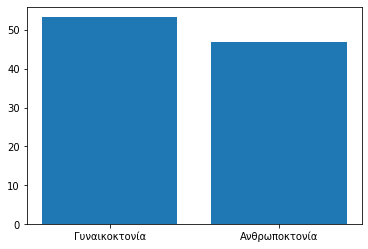

text     0
label    0
dtype: int64

In [15]:
label_distribution = (df['label'].value_counts() * 100) / len(df)
plt.bar(label_distribution.index, label_distribution)
# See class distribution:
plt.show()

# See missing values:
df.isna().sum()

## Split data set to train, validate and test:

In [17]:
# df_train, df_test = model_selection.train_test_split(df, test_size=0.2, random_state=25)

# Split to train validate and test
df_train, df_validate, df_test = np.split(df.sample(frac=1, random_state=42), [
                                          int(.6*len(df)), int(.8*len(df))])

print(f"No. of training examples: {df_train.shape[0]}")
print(f"No. of testing examples: {df_test.shape[0]}")
print(f"No. of validating examples: {df_validate.shape[0]}")

# Get X_train, y_train, X_val, y_val, X_test, y_test

X_train = df_train['text']
y_train = df_train['label']

X_val = df_validate['text']
y_val = df_validate['label']

X_test = df_test['text']
y_test = df_test['label']

No. of training examples: 310
No. of testing examples: 104
No. of validating examples: 103


## Build some Pipelines:

### Naive Bayes:

In [18]:
text_clf_NB = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf_NB.fit(X_train, y_train)

predicted = text_clf_NB.predict(X_val)
np.mean(predicted == y_val)

print(metrics.classification_report(y_val, predicted))

cfmtx_NB = pd.DataFrame(metrics.confusion_matrix(y_val, predicted), index=[
                     'Ανθρωποκτονία', 'Γυναικοκτονία'], columns=['Ανθρωποκτονία', 'Γυναικοκτονία'])

cfmtx_NB

               precision    recall  f1-score   support

Ανθρωποκτονία       1.00      0.63      0.77        57
Γυναικοκτονία       0.69      1.00      0.81        46

     accuracy                           0.80       103
    macro avg       0.84      0.82      0.79       103
 weighted avg       0.86      0.80      0.79       103



,Ανθρωποκτονία,Γυναικοκτονία
Ανθρωποκτονία,36,21
Γυναικοκτονία,0,46


### Linear Support Vector Machines:

In [19]:
text_clf_SVM = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

text_clf_SVM.fit(X_train, y_train)

predicted = text_clf_SVM.predict(X_val)
np.mean(predicted == y_val)

print(metrics.classification_report(y_val, predicted))

cfmtx_SVM = pd.DataFrame(metrics.confusion_matrix(y_val, predicted), index=[
                     'Ανθρωποκτονία', 'Γυναικοκτονία'], columns=['Ανθρωποκτονία', 'Γυναικοκτονία'])

cfmtx_SVM

               precision    recall  f1-score   support

Ανθρωποκτονία       0.93      0.95      0.94        57
Γυναικοκτονία       0.93      0.91      0.92        46

     accuracy                           0.93       103
    macro avg       0.93      0.93      0.93       103
 weighted avg       0.93      0.93      0.93       103



,Ανθρωποκτονία,Γυναικοκτονία
Ανθρωποκτονία,54,3
Γυναικοκτονία,4,42
